# Vorgehen
In diesem Dokument wird der Pre-Processing Prozess aufgezeigt. Die Daten aus dem erhaltenen Extract werden in folgender Reihenfolge abgearbeitet:
1. Stop word removal
1. Stemming
1. Tokenization
1. Vokabular
    * Lexikalischer Reichtum
    * Häufigkeitsverteilung
    * Hapaxen

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

extract = '../01_data/chatbot_all_tickets.csv'
names=['ticket', 'customer', 'inquiry', 'state', 'answer']

corpus = pd.read_csv(extract, sep=';', encoding='utf-8', names=names, skiprows=[0], usecols=[2, 3, 4, 5, 6])
corpus['inquiry'] = corpus['inquiry'].str.lower()
corpus.drop_duplicates(subset='inquiry', keep='first', inplace=True)
corpus.dropna(axis='rows', how='any', inplace=True)

all_answers = list(set(corpus.answer))
all_answers.sort()
corpus.drop(corpus[
    (corpus.answer == all_answers[0])  | 
    (corpus.answer == all_answers[1])  | 
    (corpus.answer == all_answers[2])  | 
    (corpus.answer == all_answers[3])  | 
    (corpus.answer == all_answers[10])  | 
    (corpus.answer == all_answers[22]) | 
    (corpus.answer == all_answers[23]) | 
    (corpus.answer == all_answers[24]) | 
    (corpus.answer == all_answers[25]) | 
    (corpus.answer == all_answers[26]) | 
    (corpus.answer == all_answers[27])
].index, inplace=True)
corpus['answer'].replace({
    'Anmeldung-HinweisefürAktivierung': 'Anmeldung - Hinweise für Aktivierung',
    'CouponeinlösenProduktenichtvorhanden': 'Coupon einlösen Produkte nicht vorhanden',
    'FloatingLizenzGeräteentferntKonfiguration': 'Floating Lizenz Geräte entfernt Konfiguration',
    'Linx': 'Linux',
    'Mac:AccessDenied->CookiesVirenscanner': 'Mac: Access Denied -> Cookies Virenscanner',
    'Mac:AccessDenied->CookiesVirenscanner': 'Mac: Access Denied -> Cookies Virenscanner',
    'Mac: Access Denied -> Cookies': 'Mac: Access Denied -> Cookies Virenscanner',
    'Mc: Access Denied -> Cookies Virenscnner': 'Mac: Access Denied -> Cookies Virenscanner',
    'Mac:EnableCookies': 'Mac: Enable Cookies'
}, inplace=True)

corpus.describe()

,ticket,customer,inquiry,state,answer
count,2754,2754,2754,2754,2754
unique,8,31,2754,16,9
top,Fehler in der App,hep,ich habe alle meine e-books auf einem gerät m...,closed successful,Mac: Access Denied -> Cookies Virenscanner
freq,1167,691,1,1698,1477


### 1. Stop word removal
Als erster Schritt werden alle unbedeutenden Wörter wie z.B _und_, _ein_, _als_ etc. von den _inquiries_ entfernt.

In [3]:
import re
from nltk.corpus import stopwords

stop_words = stopwords.words('german')
stop_words.extend([''])

def without_stop_words(text):
    text = re.sub(r'[^\u00C0-\u017Fa-zA-Z\s]', '', text, re.I | re.A)
    return str.join(' ', [t for t in text.split(' ') if not t in stop_words])

In [4]:
for i, inquiry in enumerate(corpus['inquiry']):
    corpus['inquiry'][i] = without_stop_words(inquiry)

In [5]:
corpus.head()

,ticket,customer,inquiry,state,answer
0,Fehler in der App,SVBA,bilder übungen bearbeiten beook schonn zeichnu...,closed_waiting_for_reply,Coupon einlösen Produkte nicht vorhanden
1,Fehler in der App,hep,lehrmittel aktualisieren jedoch geht kommt gle...,new,Mac: Access Denied -> Cookies Virenscanner
2,Anmeldung / Aktivierung,hep,problem anmeldung coupong mer enziffern ichdas...,new,Mac: Access Denied -> Cookies Virenscanner
3,Anmeldung / Aktivierung,VELEDES,neu anmelden steht abk auszug aktivierungscode...,new,Mac: Access Denied -> Cookies Virenscanner
4,Geräteanzahl überschritten,VELEDES,heruntergeladen kommt immer meldung gerätezahl...,new,Mac: Access Denied -> Cookies Virenscanner


**Gute Sätze**

Wie sehen ein paar gute Sätze nach der stop word Entfernung aus?

In [6]:
word = 5
mask = (corpus['inquiry'].str.len() > 50 * word)
good_inquiries = corpus.loc[mask].inquiry

for i, msg in enumerate(good_inquiries[:5]):
    print('Bsp.', i, '\t', msg, '\n')

Bsp. 0 	  leider kann ich die integrierten videos der app injektionen auf meinem endgerät laptop nicht abspielen. das programm meldet folgende fehlermeldung: \"no compatible source was found for this video\". ich habe es sowohl mit java als auch mit adobe flash ausprobiert. über ihre hilfe und einen lösungsweg freue ich mich. mit freundlichen grüßen  

Bsp. 1 	  leider fehlen mir paar kapitel im lehrmittel lm-a d. eins davon brauche ich jetzt in der schule heizungs- und lüftungsanlagen ich habe die app mehrfach gelöscht und neu installiert funktioniert trotzdem nicht. computer habe ich auch schon heruntergefahren. ich bitte sie um hilfe. ich wünsche ihnen einen schönen tag. freundliche grüsse  

Bsp. 2 	  ich kann die bilder nicht mehr öffnen um mit dem editorprogramm diese zu bearbeiten. freundliche grüsse  

Bsp. 3 	 bei mir zeigt es bei einigen büchern geräteanzahl überschritten. ich habe aber nie ein weiteres gerät angemeldet. zudem sollte dies ja sonst bei allen büchern der fall s

### 2. Stemming
Als zweiten Schritt werden alle Wörter auf eine Wurzel Form gekürzt. Im gegensatz zu Lemming ist das Resultat von Stemming nicht grammatikalisch korrekt.

In [7]:
from nltk.stem.snowball import SnowballStemmer

snowball = SnowballStemmer('german', ignore_stopwords=True)

def stem(text):
    return str.join(' ', [snowball.stem(t) for t in text.split(' ')])

In [8]:
for i, inquiry in enumerate(corpus['inquiry']):
    corpus['inquiry'][i] = stem(inquiry)

In [9]:
corpus.head()

,ticket,customer,inquiry,state,answer
0,Fehler in der App,SVBA,bilder übungen bearbeiten beook schonn zeichnu...,closed_waiting_for_reply,Coupon einlösen Produkte nicht vorhanden
1,Fehler in der App,hep,lehrmittel aktualisieren jedoch geht kommt gle...,new,Mac: Access Denied -> Cookies Virenscanner
2,Anmeldung / Aktivierung,hep,problem anmeldung coupong mer enziffern ichdas...,new,Mac: Access Denied -> Cookies Virenscanner
3,Anmeldung / Aktivierung,VELEDES,neu anmelden steht abk auszug aktivierungscode...,new,Mac: Access Denied -> Cookies Virenscanner
4,Geräteanzahl überschritten,VELEDES,heruntergeladen kommt immer meldung gerätezahl...,new,Mac: Access Denied -> Cookies Virenscanner


**Gute Sätze**

Wie sehen ein paar gute Sätze nach der stop word Entfernung aus?

In [10]:
word = 5
mask = (corpus['inquiry'].str.len() > 50 * word)
good_inquiries = corpus.loc[mask].inquiry

for i, msg in enumerate(good_inquiries[:5]):
    print('Bsp.', i, '\t', msg, '\n')

Bsp. 0 	  guten tag bei mir funktioniert das beook tiptop. ich schreibe im auftrag von nicole boschung.  

Bsp. 1 	 meine email ist nicht verfügbar. auch nur mit dem anmeldenamen geht es nicht. ihk passwort wfw-018-06 möchte auch nicht.  

Bsp. 2 	 mir löschtes immer alle eingaben beim buch gg!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  

Bsp. 3 	  ich wollte sie darum bitten die 2 geräte zu deaktivieren da die geräte nicht mehr gebraucht werden können und ich jetzt gerne ein anderes gerät benutzen möchte da die momentanen geräte defekt sind. für ihre bemühungen danke ich ihnen. mit freundlichen grüssen  

Bsp. 4 	  ich habe ein problem. ich kann seit gut einem monat nichts mehr richtig markieren. es markiert nur noch teilweise 

### 3. Tokenization
In einem ersten Schritt werden alle _inquiries_ gesammelt und in einzelne Wörter zerlegt.

In [11]:
from nltk.tokenize import word_tokenize

corpus['inquiry_tokens'] = corpus['inquiry'].apply(word_tokenize)
corpus.head()

,ticket,customer,inquiry,state,answer,inquiry_tokens
0,Fehler in der App,SVBA,bilder übungen bearbeiten beook schonn zeichnu...,closed_waiting_for_reply,Coupon einlösen Produkte nicht vorhanden,"[bild, ubung, bearbeit, beook, schonn, zeichnu..."
1,Fehler in der App,hep,lehrmittel aktualisieren jedoch geht kommt gle...,new,Mac: Access Denied -> Cookies Virenscanner,"[lehrmittel, aktualisi, jedoch, geht, kommt, g..."
2,Anmeldung / Aktivierung,hep,problem anmeldung coupong mer enziffern ichdas...,new,Mac: Access Denied -> Cookies Virenscanner,"[probl, anmeld, coupong, mer, enziff, ichdas, ..."
3,Anmeldung / Aktivierung,VELEDES,neu anmelden steht abk auszug aktivierungscode...,new,Mac: Access Denied -> Cookies Virenscanner,"[neu, anmeld, steht, abk, auszug, aktivierungs..."
4,Geräteanzahl überschritten,VELEDES,heruntergeladen kommt immer meldung gerätezahl...,new,Mac: Access Denied -> Cookies Virenscanner,"[heruntergelad, kommt, imm, meldung, geratezah..."


Jetzt können wir aus den Tokens ein Vocabular erstellen um zu sehen wieviele Wörter vorhanden sind.

### 4. Vokabular
Das Vocabular umfasst **546** Wörter.

In [14]:
inquiry_tokens = [item for sublist in corpus['inquiry_tokens'] for item in sublist]

vocab = list(set(inquiry_tokens))
vocab.sort()

print(f'Wörter: {len(inquiry_tokens)}')
print(f'Vokabular: {len(vocab)}')
vocab[0:10]

Wörter: 49896
Vokabular: 6540


['!', '#', '%', '&', "''", '-', '-konditor', '.', '...', '/']

#### Lexikalischer Reichtum

In [16]:
print(f'Lexikalischer Reichtum: {len(vocab) / len(inquiry_tokens)}')

Lexikalischer Reichtum: 0.13107263107263106


#### Häufigkeitsverteilung von Wörtern

In [17]:
from nltk import FreqDist

fdist1 = FreqDist(inquiry_tokens)
fdist1

FreqDist({'gruss': 900, 'bitt': 710, 'freundlich': 696, 'neu': 659, 'mehr': 537, 'dank': 506, 'anmeld': 493, 'gerat': 493, 'app': 481, 'probl': 477, ...})

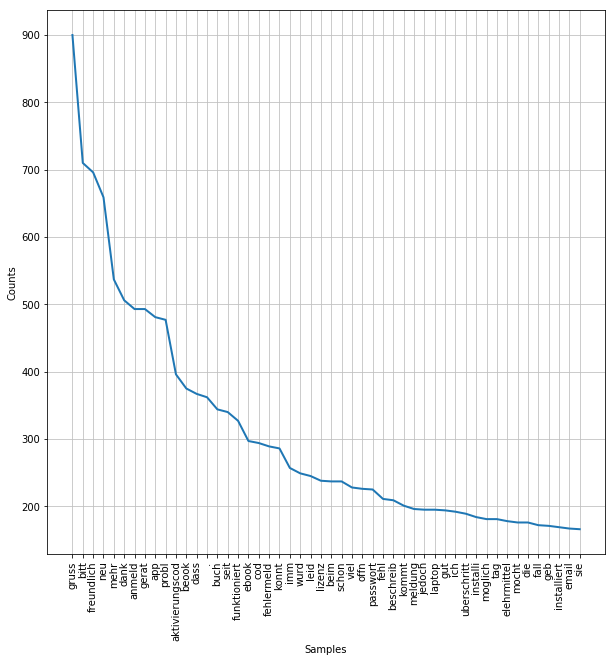

In [19]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

fdist1.plot(50, cumulative=False)

#### Hapaxen
Hapaxe sind Wörter die nur einmal vorkommen.

In [21]:
print(f'Anzahl Haxapen: {len(fdist1.hapaxes())}')
fdist1.hapaxes()[:15]

Anzahl Haxapen: 3706


['schonn',
 'enziff',
 'eingefasst',
 'fachrechnungsbuch',
 'screenhot',
 'pp',
 'rabatt',
 'deckblatt',
 'swissmemlogo',
 'richgig',
 'maln',
 'ebe',
 'gart',
 'lizenzblatt',
 'hannov']

In [22]:
for i in corpus[corpus['inquiry'].str.contains('rechenbuch')].inquiry:
    print(i, '\n')

 in meinem beook funktionieren die inhalte des fr fachrechenbuches nicht mehr. es erscheint die meldung \"geräteanzahl überschritten\". nach meinem wissen ist dieses lizenz jedoch nur auf meinem lap top und sonst nirgends installiert. können sie mit das fr-buch wieder freischalten?  

normenauszug 2018 rechenbuch metall tabellenbuchs metall fechkundebuch metall machineworld topdesign automation control konstrukteur 1 konstrukteur 2 und konstrukteur 3 funktionieren nicht mehr. es kommt die meldung „nicht mehr seiten kostenlos verfügbar“. habe alle bücher bezahlt und bis vor kurzem haben alle funktioniert.  

 am mittwoch den 14.11.18 wollte ich meine e-books benutzen. in der physik lektion brauche ich das e-book \"rechenbuch metall\" doch an diesem tag war es gelöscht. ich weiss den grund nichzt wieso. ich bin dan auf die home seite der app. da stand das ich mich anmelden soll. ich habe dies gemacht und meine e-books waren dann alle gelöscht. diese betreffen \"rechenbuch metall fachkund

# Word2Vec

In [31]:
import gensim
from gensim.models import word2vec

model = gensim.models.Word2Vec(corpus['inquiry_tokens'], size=100)
model.save('first.embedding') 
first_model = gensim.models.Word2Vec.load('first.embedding')

In [32]:
len(first_model.wv.vocab)

1281

In [35]:
first_model.wv.similar_by_word('gerateanzahl')

[('anzahl', 0.9991953372955322),
 ('geratezahl', 0.9991805553436279),
 ('gerat', 0.9991427063941956),
 ('neu', 0.9991151690483093),
 ('installiert', 0.9990799427032471),
 ('installi', 0.999065637588501),
 ('laptop', 0.9990267753601074),
 ('alt', 0.9989555478096008),
 ('losch', 0.9989020228385925),
 ('jedoch', 0.9988720417022705)]

In [45]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

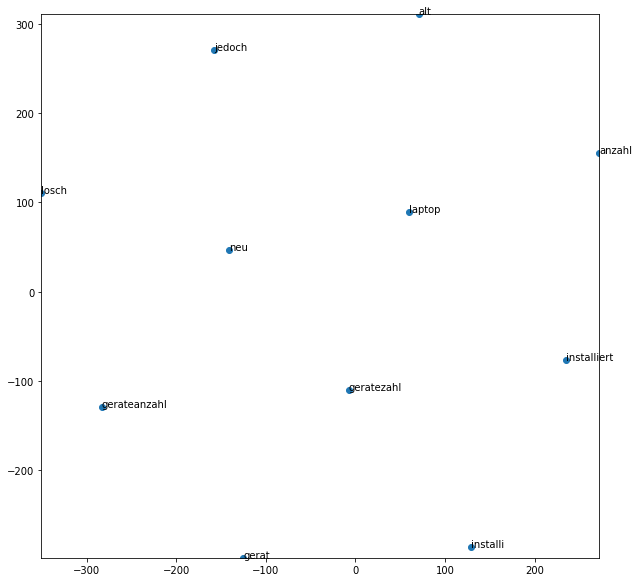

In [48]:
display_closestwords_tsnescatterplot(first_model, 'gerateanzahl')